In [2]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import sklearn  as skl
from numpy import asarray

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline      
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier
from sklearn.svm           import SVC

In [3]:
data = pd.read_csv(r'C:\Users\rnr31\Documents\GitHub\apple_watch_tracker\Datasets\dataset_0.5sec.csv')

In [4]:
oe = OrdinalEncoder()
ct = asarray(data['user'])
data['user'] = oe.fit_transform(ct.reshape(-1,1))
data = data.sort_values(by='user')
data

,Unnamed: 0,id,time,activityrecognition#0,activityrecognition#1,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.game_rotation_vector#mean,...,sound#mean,sound#min,sound#max,sound#std,speed#mean,speed#min,speed#max,speed#std,target,user
62584,62584,84508,630.0,NaN,100.0,15.892297,15.892297,15.892297,3.606631,0.838142,...,89.730876,89.730876,89.730876,NaN,0.75,0.75,0.75,NaN,Walking,0.0
21106,21106,8609,234.0,NaN,100.0,10.142241,10.142241,10.142241,0.007413,0.840593,...,89.770732,89.770732,89.770732,NaN,13.50,13.50,13.50,NaN,Car,0.0
21105,21105,22422,1727.0,NaN,8.0,10.033811,9.701954,10.334343,0.317356,0.890862,...,89.794108,89.794108,89.794108,NaN,20.50,20.50,20.50,NaN,Car,0.0
21104,21104,11240,1151.0,NaN,100.0,10.044192,9.843447,10.144604,0.173851,0.772161,...,NaN,NaN,NaN,NaN,32.50,32.50,32.50,NaN,Car,0.0
21103,21103,7828,289.0,NaN,85.0,8.514446,8.514446,8.514446,0.062750,0.734319,...,89.738523,89.738523,89.738523,NaN,12.25,12.25,12.25,NaN,Car,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37690,37690,129745,309.0,NaN,8.0,10.805771,10.805771,10.805771,0.102640,NaN,...,71.595672,71.595672,71.595672,NaN,NaN,NaN,NaN,NaN,Train,12.0
37689,37689,129760,324.0,NaN,8.0,10.389200,10.389200,10.389200,0.019366,NaN,...,68.089832,68.089832,68.089832,NaN,NaN,NaN,NaN,NaN,Train,12.0
37688,37688,131014,1578.0,NaN,8.0,10.718977,10.704910,10.733045,0.019895,NaN,...,70.312179,70.312179,70.312179,NaN,NaN,NaN,NaN,NaN,Train,12.0
37699,37699,130782,1346.0,NaN,8.0,10.551876,10.463580,10.686567,0.118512,NaN,...,68.048667,68.048667,68.048667,NaN,NaN,NaN,NaN,NaN,Train,12.0


In [5]:
def col_names_change(data):
    data.drop(['Unnamed: 0','id', 'activityrecognition#0'],axis=1, inplace=True)
    data_col = ['time','activityrecognition_1']
    for i in data.columns[2:58]:
        b = i.split('.')[2].split('#')
        data_col.append(f'{b[0]}_{b[1]}')

    for i in data.columns[58:66]:
        b = i.split('#')
        data_col.append(f'{b[0]}_{b[1]}')

    data_col.append('target')
    data_col.append('user')
    data = pd.DataFrame.from_records(data.values)
    data.columns = data_col

    return data

In [6]:
data = col_names_change(data)

In [7]:
data.drop(['pressure_mean', 'pressure_max', 'pressure_min', 'pressure_std', 'sound_std', 'speed_std','step_counter_mean','step_counter_std','light_std',
            'proximity_mean','proximity_min','proximity_max','proximity_std', 'step_counter_min', 'step_counter_max' ], axis=1, inplace=True)


In [8]:
data['target']= data['target'].apply({'Bus':0, 'Car':1, 'Still':2, 'Train':3, 'Walking':4}.get)

In [9]:
df0 = data[data['target']==0]
df1 = data[data['target']==1]
df2 = data[data['target']==2]
df3 = data[data['target']==3]
df4 = data[data['target']==4]

In [10]:
def fill_nan_values(tsdf):
    for i in tsdf.columns:
        ndf = tsdf.groupby(['target'])[f'{i}'].mean()
        mn = ndf.values[0]
        tsdf[f'{i}'] = tsdf[f'{i}'].fillna(mn)
    return tsdf

df0 = fill_nan_values(df0)
df1 = fill_nan_values(df1)
df2 = fill_nan_values(df2)
df3 = fill_nan_values(df3)
df4 = fill_nan_values(df4)


C:\Users\rnr31\AppData\Local\Temp\ipykernel_11260\529956952.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsdf[f'{i}'] = tsdf[f'{i}'].fillna(mn)


In [11]:
data = pd.concat([df0, df1, df2, df3, df4])
data = data.sort_values(by='user')
data.drop(['user'], axis=1, inplace=True)

In [12]:
data.to_csv('corr.csv')

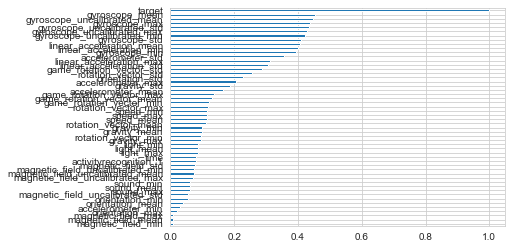

In [13]:
data.corr()['target'].abs().sort_values().plot(kind = 'barh')
sns.set(rc={'figure.figsize':(26,12)});

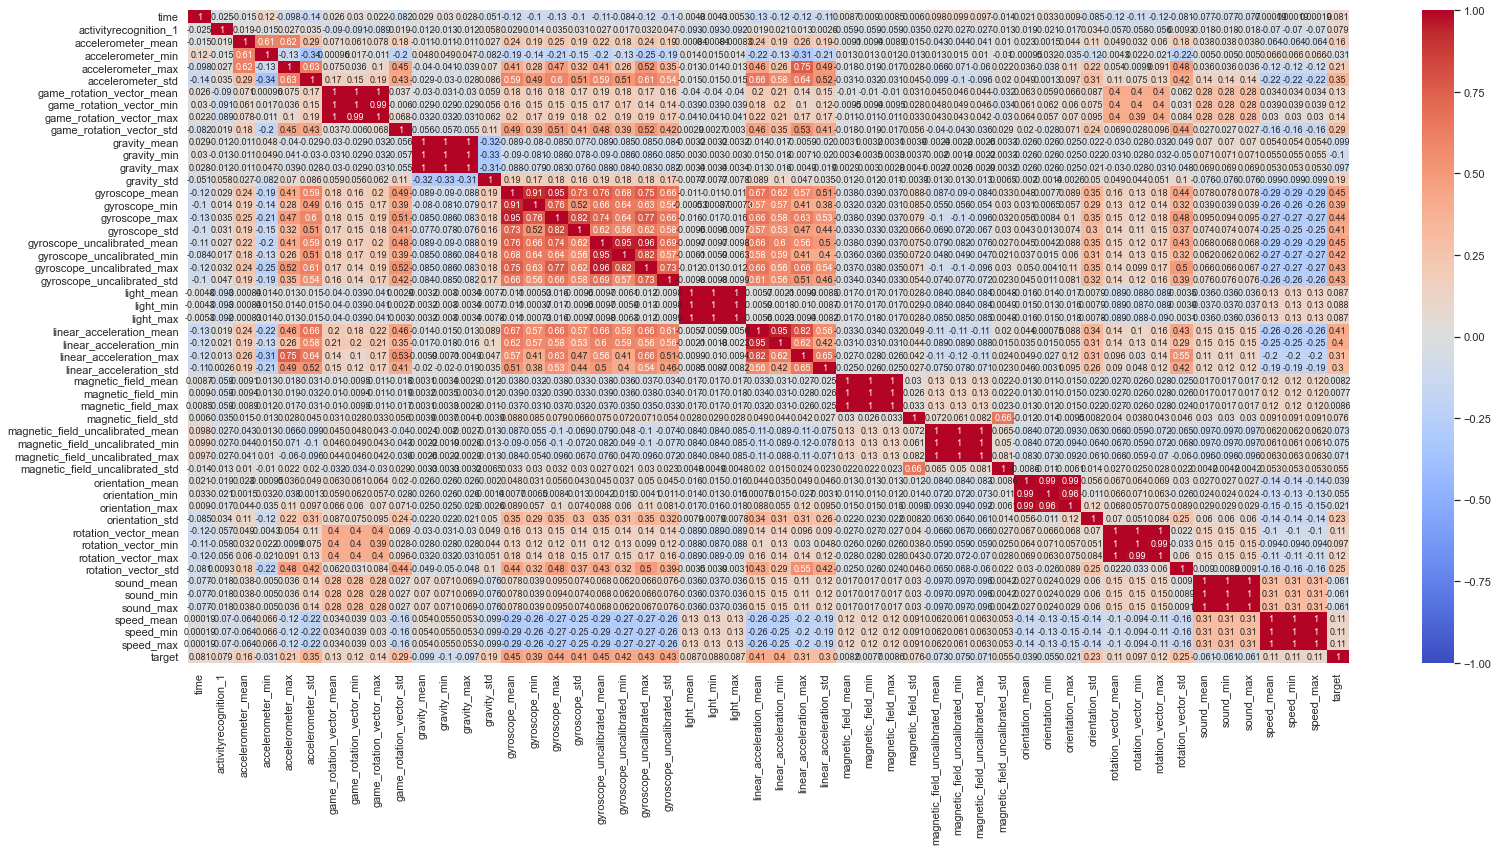

In [14]:
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', annot_kws={'size':9})
sns.set(rc={'figure.figsize':(35,19)});

In [16]:
df = pd.read_csv(r'C:\Users\rnr31\Documents\GitHub\apple_watch_tracker\Jupyter notebooks\lgbm.csv')
df

,Model,Accuracy,Bal Acc.,Time
0,Benchmark,60.200000,61.234224,7.187240
1,Feature Engineering,81.523077,80.851331,3.228405
2,Hyper parameter tuning,83.057692,81.888601,2.106158


In [19]:
for i,j in enumerate(df['Model']):
    print(df.at[i,'Accuracy'])
    print(i)
    print(j)

60.2
0
Benchmark
81.5230769230769
1
Feature Engineering
83.05769230769229
2
Hyper parameter tuning


In [22]:
c = df['Accuracy']
c

0    60.200000
1    81.523077
2    83.057692
Name: Accuracy, dtype: float64

In [20]:
lgbm_pred = ['Bus', 'Still','Train','Walking','Car']
ndt = [100,200,300,50,60]
final_df = pd.DataFrame()
final_df['transport_mode'] = np.asarray(lgbm_pred)
final_df['time'] = ndt
cal_col = []
for i,j in enumerate(final_df['transport_mode']):
    if j == 'Bus':
        t = final_df.at[i,'time']
        cal = 0.03*t
        cal_col.append(cal)
    elif j == 'Car':
        t = final_df.at[i,'time']
        cal = 0.07*t
        cal_col.append(cal)  
    elif  j =='Still' :
        t = final_df.at[i,'time']
        cal = 0.05*t
        cal_col.append(cal) 
    elif j=='Train':
        t = final_df.at[i,'time']
        cal = 0.03*t
        cal_col.append(cal)
    else:
        t = final_df.at[i,'time']
        cal = 0.1*t
        cal_col.append(cal)

final_df['calories burned'] = cal_col
final_df

,transport_mode,time,calories burned
0,Bus,100,3.0
1,Still,200,10.0
2,Train,300,9.0
3,Walking,50,5.0
4,Car,60,4.2


In [ ]:
a = [['Bus'],['Car']]
